# Отток сотрудников

Задача кажется банальной, попробуем решить ее на разных датасетах и обсудим что получается и как применять построенные модели

датасеты
1. https://www.kaggle.com/datasets/kmldas/hr-employee-data-descriptive-analytics/data HR_Employee_Data.xlsx

и он же https://www.kaggle.com/datasets/mohamedjafirashraf/hr-data-analysis HR Data Analytics.xlsx

2. https://data.world/aaizemberg/hr-employee-attrition  WA_Fn-UseC_-HR-Employee-Attrition.tsv.txt

и его расширенная версия (а может просто случайно 30+ названий колонок совпало и число строк) https://www.kaggle.com/datasets/saadharoon27/hr-analytics-dataset HR_Analytics.csv


3. https://www.kaggle.com/datasets/rhuebner/human-resources-data-set/data   HRDataset_v14.csv

In [2]:
!pip install scikit-learn==1.4.2 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 41.0 MB/s eta 0:00:00


In [1]:
pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.8 MB/s eta 0:00:00


In [4]:
!pip install hyperopt -q

In [5]:
import numpy as np
import pandas as pd
from numpy.random import RandomState
import hyperopt
from catboost import metrics, cv, Pool, CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from tabulate import tabulate
from sklearn.ensemble import RandomForestClassifier

# Задача 1
[модифицированный датасет компании MNC](https://www.kaggle.com/datasets/kmldas/hr-employee-data-descriptive-analytics/data)

photo-1504384308090-c894fdcc538d.avif

In [407]:

df = pd.read_excel('HR_Employee_Data.xlsx')
# https://www.kaggle.com/datasets/kmldas/hr-employee-data-descriptive-analytics/data
df.columns

Index(['Emp_Id', 'satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [408]:
# похоже на таргет
df['left'].value_counts()

left
0    11428
1     3571
Name: count, dtype: int64

Очень большой event rate. Вероятность угадать случайно:

In [409]:
round(df[df['left'] == 1]['left'].count() / df.shape[0], 2)

0.24

24% ! изрядная текучка

In [410]:
df['satisfaction_level'].value_counts()

satisfaction_level
0.10    358
0.11    335
0.74    257
0.77    252
0.84    247
       ... 
0.25     34
0.28     31
0.27     30
0.26     30
0.12     30
Name: count, Length: 92, dtype: int64

In [411]:
df.shape

(14999, 11)

satisfaction_level похож на данные опроса, но он здесь явно киллер фичей выступает

In [413]:
2 * roc_auc_score(df.left, df.satisfaction_level) -1

-0.49587712513601034

<Axes: >

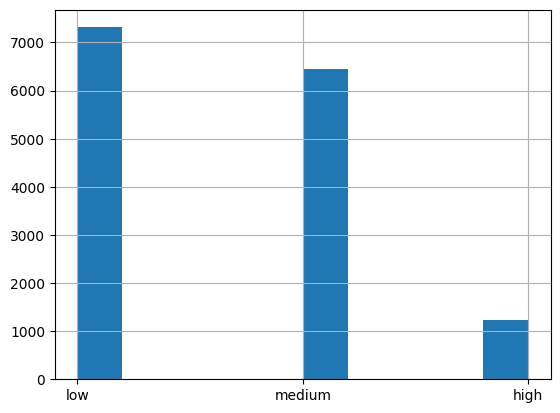

In [414]:
df.salary.hist()

<Axes: >

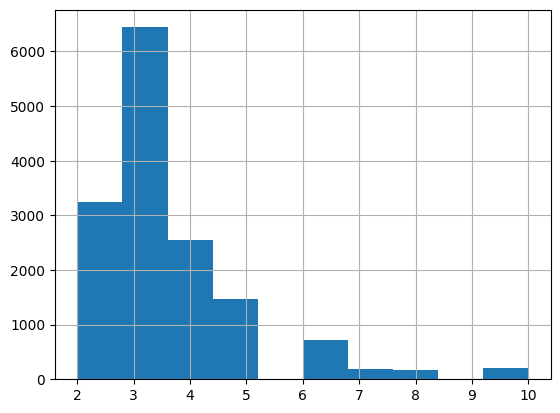

In [415]:
df.time_spend_company.hist()

<Axes: >

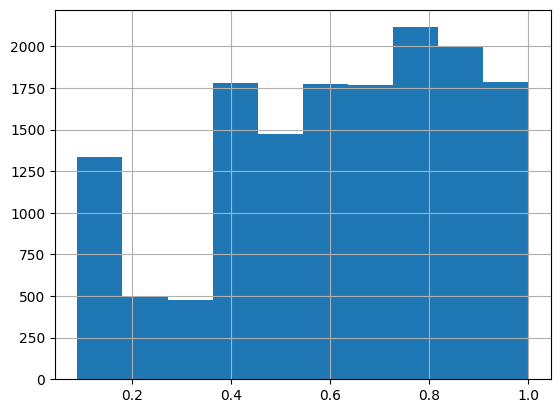

In [416]:
df.satisfaction_level.hist()

In [417]:
df['salary_code'] = df['salary'].map({'low' : 1, 'medium' : 2, 'high' : 3})
df[['time_spend_company', 'satisfaction_level', 'left', 'salary_code']].corr()

time_spend_company  satisfaction_level      left  \
time_spend_company            1.000000           -0.100866  0.144822   
satisfaction_level           -0.100866            1.000000 -0.388375   
left                          0.144822           -0.388375  1.000000   
salary_code                   0.048715            0.050022 -0.157898   

                    salary_code  
time_spend_company     0.048715  
satisfaction_level     0.050022  
left                  -0.157898  
salary_code            1.000000

In [418]:
df['strata'] = df.salary.astype(str) + '_' + df.Department.astype(str)
x = df.drop(['salary', 'Emp_Id', 'left'], axis = 1).copy()
y = df['left'].copy()
x_train, x_oos, y_train, y_oos = train_test_split(x, y, test_size=0.2, random_state=0, stratify = df[['strata']])
x_train.drop('strata', axis = 1, inplace = True)
x_oos.drop('strata', axis = 1, inplace = True)

In [419]:
(sum(y_oos) / len(y_oos) , sum(y_train) / len(y_train))

(0.22433333333333333, 0.2415201266772231)

Какая-то модель, пока даже параметры подбирать не будем

In [420]:
dep_woe = pd.crosstab(x_train['Department'],y_train, normalize='columns').assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))['woe']
dep_woe_dict = {}
deps = [x for x in x_train.Department.unique()]
for dep in deps:
  dep_woe_dict[dep] = dep_woe.loc[dep]
x_train['Department'] = x_train['Department'].map(dep_woe_dict)
x_oos['Department'] = x_oos['Department'].map(dep_woe_dict)

In [421]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
2 * roc_auc_score(y_oos, rf.predict_proba(x_oos)[:, 1]) - 1

0.9885886399786472

In [422]:
print(tabulate([(x, y) for x, y in zip(rf.feature_names_in_, rf.feature_importances_)], headers = ['feature', 'importance']))

feature                  importance
---------------------  ------------
satisfaction_level      0.339914
last_evaluation         0.115861
number_project          0.181229
average_montly_hours    0.148892
time_spend_company      0.18737
Work_accident           0.00514636
promotion_last_5years   0.000714117
Department              0.0124385
salary_code             0.00843411


c Gini 99 на тесте особо ничего не поделать в данном кейсе, к сожалению
Однако, прежде чем перейти к использованию, давайте посмотрим что будет с моделью без киллер фичи
а потом посмотрим насколько бизнес-ожидаемо модель интерпретирует фичи

In [423]:
rf.fit(x_train.drop('satisfaction_level', axis = 1), y_train)
2 * roc_auc_score(y_oos, rf.predict_proba(x_oos.drop('satisfaction_level', axis = 1))[:,1]) - 1

0.9820627544983593

In [424]:
from tabulate import tabulate
print(tabulate([(x, y) for x, y in zip(rf.feature_names_in_, rf.feature_importances_)], headers = ['feature', 'importance']))

feature                  importance
---------------------  ------------
last_evaluation          0.187789
number_project           0.288129
average_montly_hours     0.242797
time_spend_company       0.219401
Work_accident            0.0149351
promotion_last_5years    0.00240086
Department               0.0275228
salary_code              0.0170253


In [425]:
from sklearn.inspection import PartialDependenceDisplay

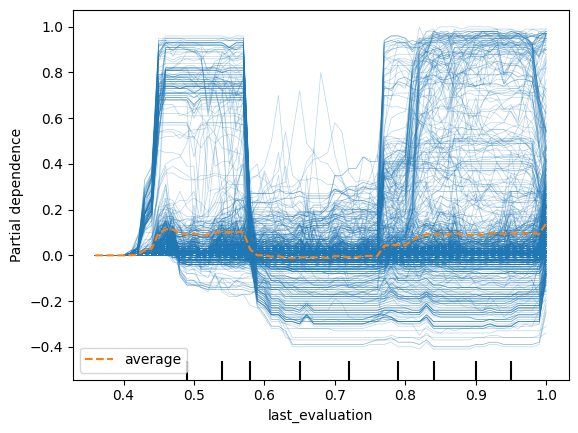

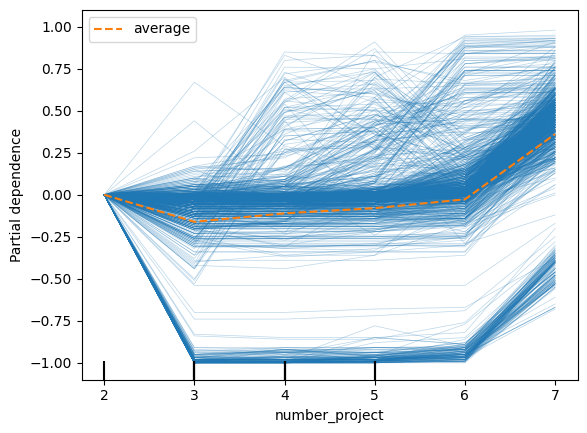

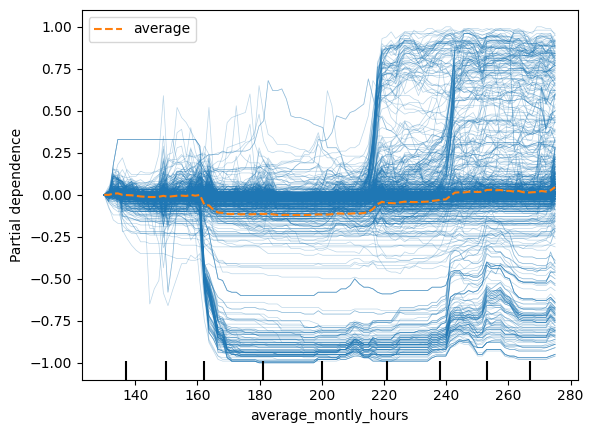

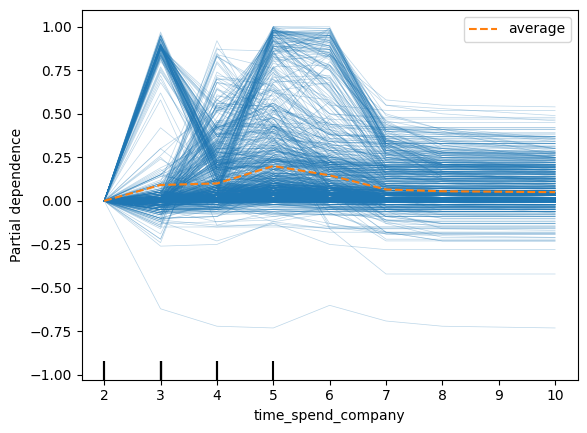

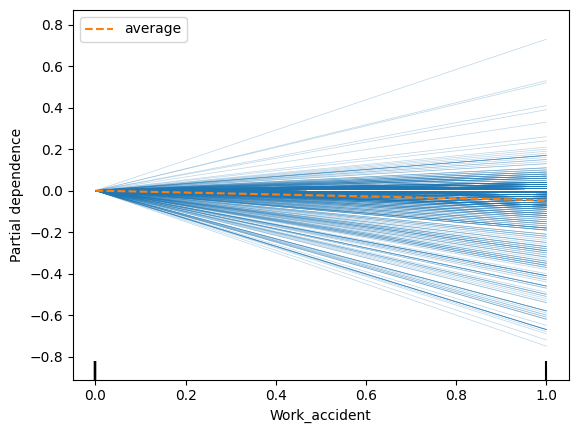

In [426]:
for k in range(5):
  PartialDependenceDisplay.from_estimator(rf, x_train.drop('satisfaction_level', axis = 1), [k], kind='both', centered=True)

вот не сказать что модель супер-предсказуема для бизнеса. Припаркуем на время вопрос и перейдем наконец к главному

In [427]:
preds = pd.concat([y_oos, pd.Series(data = rf.predict_proba(x_oos.drop('satisfaction_level', axis = 1))[:,1], index = y_oos.index, name = 'proba')
                                  , pd.Series(data = rf.predict(x_oos.drop('satisfaction_level', axis = 1)), index = y_oos.index, name = 'prediction')]
                                  , axis = 1)

Пример сценария использования модели -- отбирать 10% самых рисковых и передавать их начальнку начальника и HR BP

In [428]:
top_risk = preds.sort_values('proba', ascending = False).head(len(y_oos) // 10).copy()
top_risk[top_risk['left'] == top_risk['prediction']]['left'].count() / top_risk['left'].count()

0.9933333333333333

С таким датасетом ошибиться сложно, попробуем найти ситуацию похуже и попробуем оптимизировать нужную метрику

Но посмотрим еще раз на датасет, вернув киллер фичу.

## Фичи задача 1

In [429]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
print(2 * roc_auc_score(y_oos, rf.predict_proba(x_oos)[:, 1]) - 1)
from tabulate import tabulate
print(tabulate(sorted([(x, y) for x, y in zip(rf.feature_names_in_, rf.feature_importances_)], key=lambda x: x[1], reverse=True), headers = ['feature', 'importance']))

0.9881774197976976
feature                  importance
---------------------  ------------
satisfaction_level       0.339864
number_project           0.187157
time_spend_company       0.179644
average_montly_hours     0.137207
last_evaluation          0.128251
Department               0.0127767
salary_code              0.007809
Work_accident            0.00622141
promotion_last_5years    0.00106982


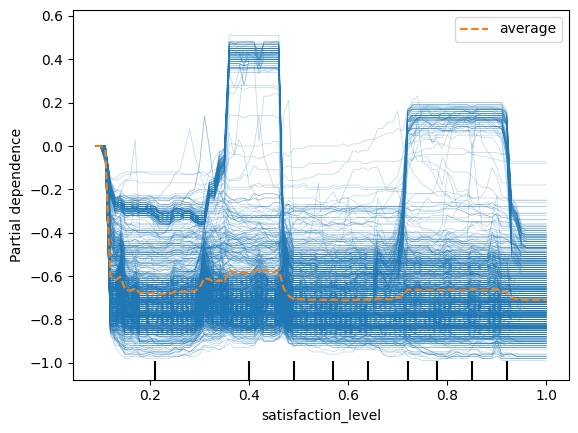

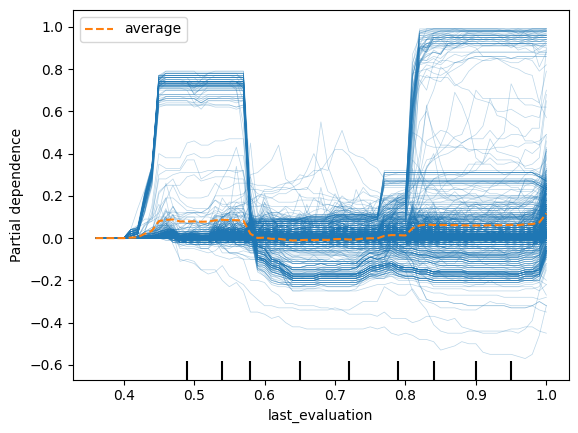

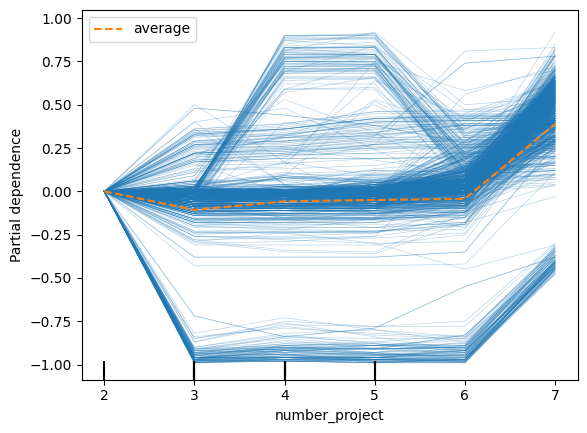

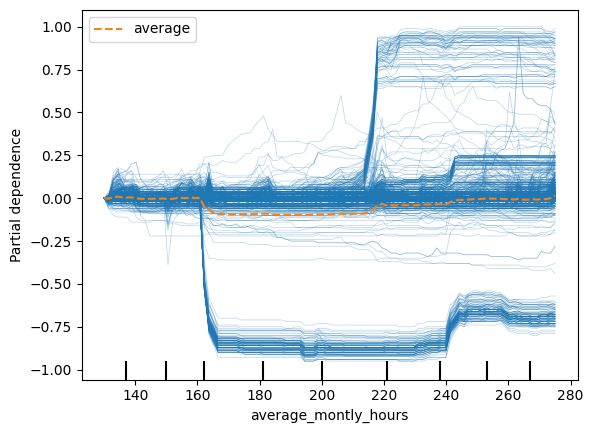

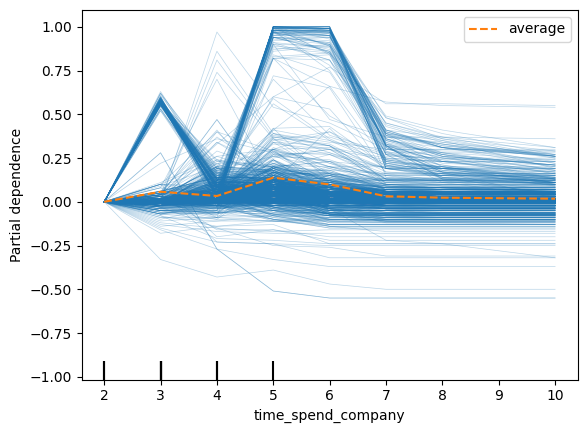

In [207]:
for k in range(5):
  PartialDependenceDisplay.from_estimator(rf, x_train, [k], kind='both', centered=True)

In [208]:
preds = pd.concat([y_oos, pd.Series(data = rf.predict_proba(x_oos)[:,1], index = y_oos.index, name = 'proba')
                                  , pd.Series(data = rf.predict(x_oos), index = y_oos.index, name = 'prediction')]
                                  , axis = 1)
top_risk = preds.sort_values('proba', ascending = False).head(len(y_oos) // 10).copy()
top_risk[top_risk['left'] == top_risk['prediction']]['left'].count() / top_risk['left'].count()

1.0

Давайте сделаем модель похуже? Заставим ее быть монотонной по Satisfaction_level

In [209]:
monotonic_cstr = np.zeros(len(x_train.columns))
monotonic_cstr[0] = 1
rf = RandomForestClassifier(monotonic_cst = monotonic_cstr)
rf.fit(x_train, y_train)
2 * roc_auc_score(y_oos, rf.predict_proba(x_oos)[:, 1]) - 1

0.974681863082836

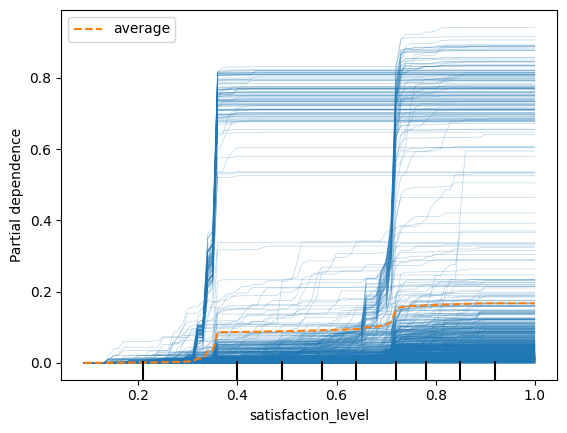

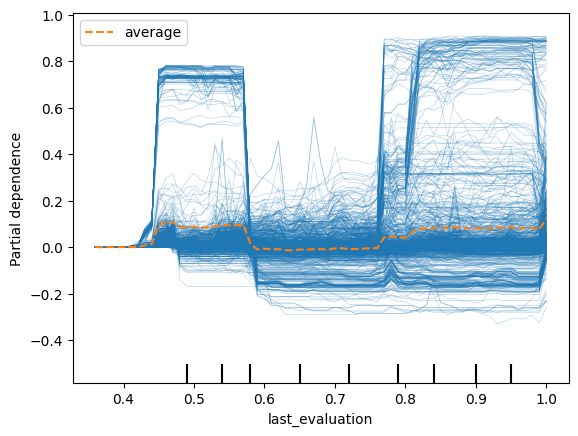

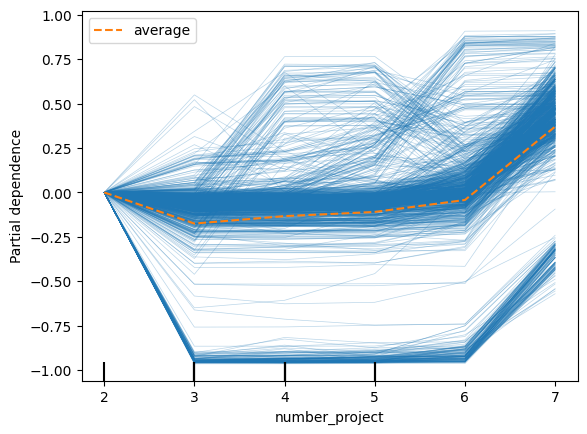

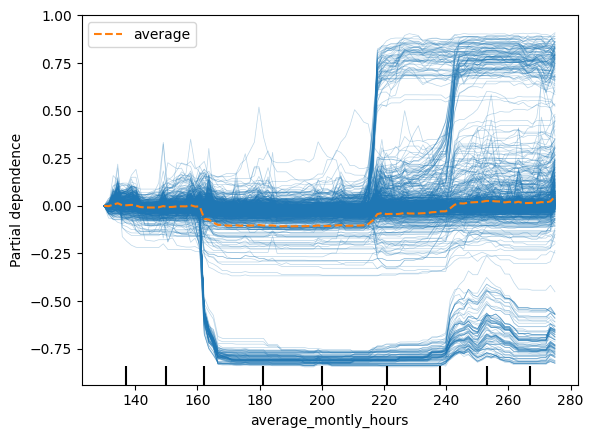

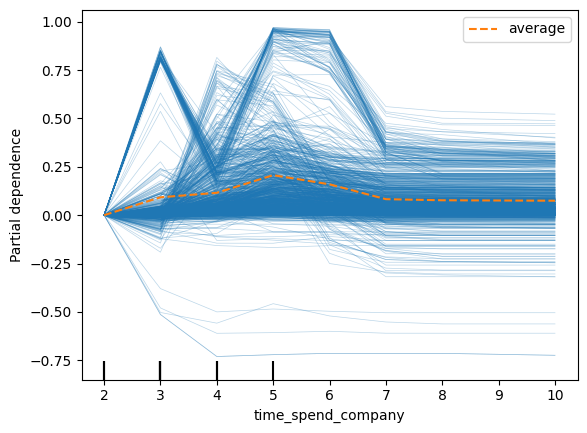

In [210]:
for k in range(5):
  PartialDependenceDisplay.from_estimator(rf, x_train, [k], kind='both', centered=True)

In [211]:
preds = pd.concat([y_oos, pd.Series(data = rf.predict_proba(x_oos)[:,1], index = y_oos.index, name = 'proba')
                                  , pd.Series(data = rf.predict(x_oos), index = y_oos.index, name = 'prediction')]
                                  , axis = 1)
top_risk = preds.sort_values('proba', ascending = False).head(len(y_oos) // 10).copy()
top_risk[top_risk['left'] == top_risk['prediction']]['left'].count() / top_risk['left'].count()

0.99

Ничего не бывает бесплатно -- за монотонность мы заплатили точностью

# Задача 2 WA_Fn-UseC_-HR-Employee-Attrition.tsv.txt

In [275]:
df2 = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.tsv.txt', sep = '\t')
# https://data.world/aaizemberg/hr-employee-attrition
df2.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [276]:
# Target
df2.Attrition = df2.Attrition.map({'No' : 0, 'Yes' : 1})

In [278]:
df2['EmployeeCount'].value_counts()

EmployeeCount
1    1470
Name: count, dtype: int64

In [279]:
df2.drop('EmployeeCount', axis = 1, inplace = True)

In [280]:
df2['Over18'].value_counts()

Over18
Y    1470
Name: count, dtype: int64

In [281]:
df2.drop('Over18', axis = 1, inplace = True)

In [282]:
df2.drop('EmployeeNumber', axis = 1, inplace = True)

In [283]:
cat_features = ['Department', 'BusinessTravel', 'Gender', 'MaritalStatus', 'Education', 'EducationField', 'JobRole','OverTime']

In [284]:
df2['StandardHours'].value_counts()

StandardHours
80    1470
Name: count, dtype: int64

In [285]:
df2.drop('StandardHours', axis = 1, inplace = True)

In [286]:
corr = df2.drop(cat_features, axis = 1).corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.6).any()
raw = corr.loc[m, m]
raw

Attrition  DailyRate  DistanceFromHome  \
Attrition                  1.000000  -0.056652          0.077924   
DailyRate                 -0.056652   1.000000         -0.004985   
DistanceFromHome           0.077924  -0.004985          1.000000   
EnvironmentSatisfaction   -0.103369   0.018355         -0.016075   
HourlyRate                -0.006846   0.023381          0.031131   
JobInvolvement            -0.130016   0.046135          0.008783   
JobSatisfaction           -0.103481   0.030571         -0.003669   
MonthlyRate                0.015170  -0.032182          0.027473   
NumCompaniesWorked         0.043494   0.038153         -0.029251   
RelationshipSatisfaction  -0.045872   0.007846          0.006557   
StockOptionLevel          -0.137145   0.042143          0.044872   
TrainingTimesLastYear     -0.059478   0.002453         -0.036942   
WorkLifeBalance           -0.063939  -0.037848         -0.026556   

                          EnvironmentSatisfaction  HourlyRate  JobInvolvement  \
Attrition                               -0.103369   -0.006846       -0.130016   
DailyRate                                0.018355    0.023381        0.046135   
DistanceFromHome                        -0.016075    0.031131        0.008783   
EnvironmentSatisfaction                  1.000000   -0.049857       -0.008278   
HourlyRate                              -0.049857    1.000000        0.042861   
JobInvolvement                          -0.008278    0.042861        1.000000   
JobSatisfaction                         -0.006784   -0.071335       -0.021476   
MonthlyRate                              0.037600   -0.015297       -0.016322   
NumCompaniesWorked                       0.012594    0.022157        0.015012   
RelationshipSatisfaction                 0.007665    0.001330        0.034297   
StockOptionLevel                         0.003432    0.050263        0.021523   
TrainingTimesLastYear                   -0.019359   -0.008548       -0.015338   
WorkLifeBalance                          0.027627   -0.004607       -0.014617   

                          JobSatisfaction  MonthlyRate  NumCompaniesWorked  \
Attrition                       -0.103481     0.015170            0.043494   
DailyRate                        0.030571    -0.032182            0.038153   
DistanceFromHome                -0.003669     0.027473           -0.029251   
EnvironmentSatisfaction         -0.006784     0.037600            0.012594   
HourlyRate                      -0.071335    -0.015297            0.022157   
JobInvolvement                  -0.021476    -0.016322            0.015012   
JobSatisfaction                  1.000000     0.000644           -0.055699   
MonthlyRate                      0.000644     1.000000            0.017521   
NumCompaniesWorked              -0.055699     0.017521            1.000000   
RelationshipSatisfaction        -0.012454    -0.004085            0.052733   
StockOptionLevel                 0.010690    -0.034323            0.030075   
TrainingTimesLastYear           -0.005779     0.001467           -0.066054   
WorkLifeBalance                 -0.019459     0.007963           -0.008366   

                          RelationshipSatisfaction  StockOptionLevel  \
Attrition                                -0.045872         -0.137145   
DailyRate                                 0.007846          0.042143   
DistanceFromHome                          0.006557          0.044872   
EnvironmentSatisfaction                   0.007665          0.003432   
HourlyRate                                0.001330          0.050263   
JobInvolvement                            0.034297          0.021523   
JobSatisfaction                          -0.012454          0.010690   
MonthlyRate                              -0.004085         -0.034323   
NumCompaniesWorked                        0.052733          0.030075   
RelationshipSatisfaction                  1.000000         -0.045952   
StockOptionLevel                         -0.045952   

In [287]:
corr_features = set(df2.columns) - set(raw.columns)
corr_features

{'Age',
 'BusinessTravel',
 'Department',
 'Education',
 'EducationField',
 'Gender',
 'JobLevel',
 'JobRole',
 'MaritalStatus',
 'MonthlyIncome',
 'OverTime',
 'PercentSalaryHike',
 'PerformanceRating',
 'TotalWorkingYears',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager'}

Фичей много, данных мало. Фичи ожидаемо (побизнес-смыслу) скоррелированы
Вариантов 3:

1.   дропнуть
2.   наинжинирить
3.   закрутить L2


In [288]:
corr = df2.drop(cat_features, axis = 1).corr()
m = (corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.6).any()
raw = corr.loc[m, m]
raw

Age  JobLevel  MonthlyIncome  PercentSalaryHike  \
Age                      1.000000  0.509604       0.497855           0.003634   
JobLevel                 0.509604  1.000000       0.950300          -0.034730   
MonthlyIncome            0.497855  0.950300       1.000000          -0.027269   
PercentSalaryHike        0.003634 -0.034730      -0.027269           1.000000   
PerformanceRating        0.001904 -0.021222      -0.017120           0.773550   
TotalWorkingYears        0.680381  0.782208       0.772893          -0.020608   
YearsAtCompany           0.311309  0.534739       0.514285          -0.035991   
YearsInCurrentRole       0.212901  0.389447       0.363818          -0.001520   
YearsSinceLastPromotion  0.216513  0.353885       0.344978          -0.022154   
YearsWithCurrManager     0.202089  0.375281       0.344079          -0.011985   

                         PerformanceRating  TotalWorkingYears  YearsAtCompany  \
Age                               0.001904           0.680381        0.311309   
JobLevel                         -0.021222           0.782208        0.534739   
MonthlyIncome                    -0.017120           0.772893        0.514285   
PercentSalaryHike                 0.773550          -0.020608       -0.035991   
PerformanceRating                 1.000000           0.006744        0.003435   
TotalWorkingYears                 0.006744           1.000000        0.628133   
YearsAtCompany                    0.003435           0.628133        1.000000   
YearsInCurrentRole                0.034986           0.460365        0.758754   
YearsSinceLastPromotion           0.017896           0.404858        0.618409   
YearsWithCurrManager              0.022827           0.459188        0.769212   

                         YearsInCurrentRole  YearsSinceLastPromotion  \
Age                                0.212901                 0.216513   
JobLevel                           0.389447                 0.353885   
MonthlyIncome                      0.363818                 0.344978   
PercentSalaryHike                 -0.001520                -0.022154   
PerformanceRating                  0.034986                 0.017896   
TotalWorkingYears                  0.460365                 0.404858   
YearsAtCompany                     0.758754                 0.618409   
YearsInCurrentRole                 1.000000                 0.548056   
YearsSinceLastPromotion            0.548056                 1.000000   
YearsWithCurrManager               0.714365                 0.510224   

                         YearsWithCurrManager  
Age                                  0.202089  
JobLevel                             0.375281  
MonthlyIncome                        0.344079  
PercentSalaryHike                   -0.011985  
PerformanceRating                    0.022827  
TotalWorkingYears                    0.459188  
YearsAtCompany                       0.769212  
YearsInCurrentRole                   0.714365  
YearsSinceLastPromotion              0.510224  
YearsWithCurrManager                 1.000000

In [290]:
x = df2.drop('Attrition', axis = 1).copy()
y = df2['Attrition'].copy()
x_train, x_oos, y_train, y_oos = train_test_split(x, y, test_size=0.2, random_state=0, stratify = y)

In [291]:
model = CatBoostClassifier(verbose=False, random_seed=42)
model.fit(x_train, y_train, cat_features = cat_features)
predictions = model.predict(x_oos)

In [292]:
print(2 * roc_auc_score(y_oos, model.predict_proba(x_oos)[:,1]) - 1)
print(2 * roc_auc_score(y_train, model.predict_proba(x_train)[:,1]) - 1)

0.646481178396072
0.9813707697234975


## Значение нашей метрики еще ниже

In [293]:
preds = pd.concat([y_oos, pd.Series(data = model.predict_proba(x_oos)[:, 1], index = y_oos.index, name = 'proba')
                          , pd.Series(data = model.predict(x_oos), index = y_oos.index, name = 'prediction')], axis = 1)
preds
top_risk = preds.sort_values('proba', ascending = False).head(len(y_oos) // 10).copy()
top_risk[(top_risk['Attrition'] == top_risk['prediction']) & (top_risk['Attrition'] == 1)]['Attrition'].count() / top_risk[top_risk['Attrition'] == 1]['Attrition'].count()

0.5517241379310345

Катбуст переобучился на 1176 точках и 30 фичах, еще и сильно скоррелированных? да не может быть).    
Плюс нам нужна специфическая метрика -- recall на топ-10% выборки.   

Что делаем:
- подбираем L2
- впихиваем кастомную метрику
- думаем, можно ли впихнуть кастомный лосс

[Кастомные лоссы и метрики катбуста](https://catboost.ai/en/docs/concepts/python-usages-examples)

In [331]:
class Top10RecallMetric(object):
  # no weights!
    def is_max_optimal(self):
        # Returns whether great values of metric are better
        return True

    def evaluate(self, approxes, target, weight):
        # approxes is a list of indexed containers
        # (containers with only __len__ and __getitem__ defined),
        # one container per approx dimension.
        # Each container contains floats.
        # weight is a one dimensional indexed container.
        # target is a one dimensional indexed container.

        # weight parameter can be None.
        # Returns pair (error, weights sum)

        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        top10recall_sum = 0.0
        weight_sum = 0.0
        x = []
        for i in range(len(approx)):
          x.append(approx[i])
          w = 1.0 if weight is None else weight[i]
          weight_sum += w

        x = sorted(x)
        const = x[round(len(x) * 9 // 10)]

        for i in range(len(approx)):
          if approx[i] > const:
            if target[i] == 1:
              top10recall_sum += 1 - abs(approx[i] - target[i])


        return top10recall_sum, weight_sum

    def get_final_error(self, error, weight):
        # Returns final value of metric based on error and weight
        return error / (weight + 1e-38)

In [391]:
def hyperopt_objective(params):
    model = CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        iterations=500,
        eval_metric=Top10RecallMetric(),
        random_seed=42,
        verbose=False,
        loss_function=metrics.Logloss(),
    )

    cv_data = cv(
        Pool(x_train, y_train, cat_features=cat_features),
        model.get_params(),
        logging_level='Silent',
    )
    best_accuracy = np.max(cv_data['test-Top10RecallMetric-mean'])

    return 1 - best_accuracy # as hyperopt minimises

In [392]:
params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=np.random.default_rng(123)
)

print(best)

100%|██████████| 50/50 [10:44<00:00, 12.89s/trial, best loss: 0.9837954392297157]
{'l2_leaf_reg': 7.0, 'learning_rate': 0.40753513729344043}


In [393]:
model = CatBoostClassifier(
    l2_leaf_reg=int(best['l2_leaf_reg']),
    learning_rate=best['learning_rate'],
    iterations=500,
    eval_metric=Top10RecallMetric(),
    random_seed=42,
    verbose=False,
    loss_function=metrics.Logloss(),
)
cv_data = cv(Pool(x_train, y_train, cat_features=cat_features), model.get_params())

Training on fold [0/3]

bestTest = 0.01892413674
bestIteration = 23

Training on fold [1/3]

bestTest = 0.01852137616
bestIteration = 22

Training on fold [2/3]

bestTest = 0.01909157942
bestIteration = 31



In [394]:
print('Precise validation  score: {}'.format(np.max(cv_data['test-Top10RecallMetric-mean'])))

Precise validation accuracy score: 0.016204560770284312


In [395]:
model.fit(Pool(x_train, y_train, cat_features=cat_features))

In [396]:
print(2 * roc_auc_score(y_oos, model.predict_proba(x_oos)[:,1]) - 1)
print(2 * roc_auc_score(y_train, model.predict_proba(x_train)[:,1]) - 1)

0.622361960547851
1.0


Катбуст все еще переобучен

In [397]:
preds = pd.concat([y_oos, pd.Series(data = model.predict_proba(x_oos)[:, 1], index = y_oos.index, name = 'proba')
                          , pd.Series(data = model.predict(x_oos), index = y_oos.index, name = 'prediction')], axis = 1)
top_risk = preds.sort_values('proba', ascending = False).head(len(y_oos) // 10).copy()
top_risk[(top_risk['Attrition'] == top_risk['prediction']) & (top_risk['Attrition'] == 1)]['Attrition'].count() / top_risk[top_risk['Attrition'] == 1]['Attrition'].count()

0.625

Но целевая метрика здорово выросла!

Как наша модель работает глазами HR BP?

In [398]:
er = df2['Attrition'].sum() / df2['Attrition'].count()
recall_top_10 = top_risk[(top_risk['Attrition'] == top_risk['prediction']) & (top_risk['Attrition'] == 1)]['Attrition'].count() / top_risk[top_risk['Attrition'] == 1]['Attrition'].count()
f"{er : 2.2f} vs {recall_top_10}"

' 0.16 vs 0.625'

In [399]:
f'HR BP mode: модель угадывает в {recall_top_10 / er: 1.0f} раза лучше случайного'

'HR BP mode: модель угадывает в  4 раза лучше случайного'

In [400]:
# значение метрики на трейне
preds = pd.concat([y_train, pd.Series(data = model.predict_proba(x_train)[:, 1], index = y_train.index, name = 'proba')
                          , pd.Series(data = model.predict(x_train), index = y_train.index, name = 'prediction')], axis = 1)
top_risk = preds.sort_values('proba', ascending = False).head(len(y_train) // 10).copy()
top_risk[(top_risk['Attrition'] == top_risk['prediction']) & (top_risk['Attrition'] == 1)]['Attrition'].count() / top_risk[top_risk['Attrition'] == 1]['Attrition'].count()

1.0

## Фичи задача 2

In [405]:
print(tabulate(sorted([(x, y) for x, y in zip(x_train.columns, model.get_feature_importance())], key=lambda x: x[1], reverse=True), headers = ['feature', 'importance']))

feature                     importance
------------------------  ------------
OverTime                      7.45513
MonthlyIncome                 6.74239
JobRole                       5.19126
Age                           4.78218
MonthlyRate                   4.76067
DistanceFromHome              4.7602
DailyRate                     4.52307
JobSatisfaction               4.19313
HourlyRate                    4.04447
NumCompaniesWorked            3.8072
StockOptionLevel              3.80074
EducationField                3.65072
RelationshipSatisfaction      3.55177
MaritalStatus                 3.47092
BusinessTravel                3.4372
EnvironmentSatisfaction       3.3578
YearsSinceLastPromotion       3.23553
TotalWorkingYears             3.1645
TrainingTimesLastYear         3.15678
PercentSalaryHike             3.07204
YearsAtCompany                2.54169
YearsWithCurrManager          2.29207
JobInvolvement                2.16147
Department                    2.14705
WorkLifeBalance

# ДЗ

Построить модель, которую можно


1.   объяснить бизнесу (PDP, ICE, etc)
2.   внедрить в прод

датасет [вот](https://www.kaggle.com/datasets/rhuebner/human-resources-data-set/data )



In [3]:
df3 = pd.read_csv('HRDataset_v14.csv')
df3.columns

Index(['Employee_Name', 'EmpID', 'MarriedID', 'MaritalStatusID', 'GenderID',
       'EmpStatusID', 'DeptID', 'PerfScoreID', 'FromDiversityJobFairID',
       'Salary', 'Termd', 'PositionID', 'Position', 'State', 'Zip', 'DOB',
       'Sex', 'MaritalDesc', 'CitizenDesc', 'HispanicLatino', 'RaceDesc',
       'DateofHire', 'DateofTermination', 'TermReason', 'EmploymentStatus',
       'Department', 'ManagerName', 'ManagerID', 'RecruitmentSource',
       'PerformanceScore', 'EngagementSurvey', 'EmpSatisfaction',
       'SpecialProjectsCount', 'LastPerformanceReview_Date', 'DaysLateLast30',
       'Absences'],
      dtype='object')

In [8]:
df3.shape

(311, 36)

In [14]:
len(df3[df3['DateofTermination'].notna()]['DateofTermination'] ) / len(df3['DateofTermination'])

0.33440514469453375

Неплохой такой отток!

In [15]:
# таргет
df3['left'] = df3['DateofTermination'].notna().map(int)